In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    dgl.seed(seed_value)
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value))
    already_installed=True

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
try:
  already_installed
except:  
    !pip install kora
    !pip install dgl
    !pip install dgl-cu101
    !pip install --pre dgl-cu101
    !pip install dgllife
    # !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
    # !pip install -q torch-geometric
    !pip install torch_optimizer
    #!pip install pytorch_lightning
    import sys
    import time
    import dgl
    import dgllife
    import torch 
    import pickle
    from IPython.display import clear_output
    import networkx as nx
    import dgl.function as fn
    import torch.nn.functional as F
    import torch.nn as nn
    sys.path.append('/usr/local/lib/python3.6/dist-packages/') # For using RDKit utilizing KORA
    import kora.install.rdkit
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    from rdkit.Chem.Draw import IPythonConsole
    from rdkit.Chem import ChemicalFeatures
    from rdkit import RDConfig
    from dgllife.utils import featurizers as fs
    from torch.utils.data import DataLoader
    import networkx as nx
    import matplotlib.pyplot as plt
    import torch_optimizer as optim
    # import pytorch_lightning as pl  
    # from pytorch_lightning.metrics.classification import AUROC
    # from pytorch_lightning.metrics.classification import AveragePrecision
    # from pytorch_lightning.metrics.classification import Recall
    # from pytorch_lightning.metrics.classification import Precision
    # from pytorch_lightning.metrics.classification import ConfusionMatrix
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    import pandas as pd
    import numpy as np
    import itertools
    import os
    %matplotlib inline
    import warnings
    warnings.filterwarnings("ignore")
    # Fix Seeds
    # Set a seed value
    seed_value= 213 
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random 
    random.seed(seed_value)
    # 3. Set `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)
    # 4. Set `pytorch` pseudo-random generator at a fixed value
    torch.manual_seed(seed_value)
    # 5. Set `dgl` pseudo-random generator at a fixed value
    dgl.seed(seed_value)
    # 6. For layers that introduce randomness like dropout, make sure to set seed values 
    # model.add(Dropout(0.25, seed=seed_value))
    already_installed=True

In [ ]:
# Data Generation 

def bond_is_in_ring_list_one_hot(bond, allowable_set=None, encode_unknown=False):
          list = [3,4,5] # List denotes the size of cycles
          return [bond.IsInRing()]+[bond.IsInRingSize(i) for i in list]

class CanonicalBondFeaturizer(fs.BaseBondFeaturizer):
       def __init__(self, bond_data_field='e', self_loop=False):
        super(CanonicalBondFeaturizer, self).__init__(
            featurizer_funcs={bond_data_field: fs.ConcatFeaturizer(
                [fs.bond_type_one_hot,
                 fs.bond_is_conjugated,
                 fs.bond_is_in_ring,
                 fs.bond_stereo_one_hot,
                 fs.bond_direction_one_hot,
                 bond_is_in_ring_list_one_hot
                 ]
            )}, self_loop=self_loop)
        
CanonicalBondFeaturizer = CanonicalBondFeaturizer()

# Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)

# Edge_features=[]
# no_edge=[]
# for i in range(Tox21_dataset.smiles.size):
#   try:
#     Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
#   except:
#     no_edge.append(i)
#     Edge_features.append('no_edge')

# Tox21_dataset.drop(no_edge, inplace=True)

# for i in range(len(no_edge)):
#   del Edge_features[no_edge[i]-i]

# %cd /content/

# if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
#   !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_features_AF_NOH.zip'

# global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').iloc[:,1:].values)
# with open('Node_features_AF_NOH.pickle', 'rb') as handle:
#     Node_features = pickle.load(handle)
1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.# for i in range(len(no_edge)):
#   del Node_features[no_edge[i]-i]

# for i in range(len(no_edge)):
#   global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

class DGLDatasetTox(torch.utils.data.Dataset):

    def __init__(self):

        Tox21_dataset = pd.read_csv('https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz', compression='gzip').fillna(0)
        
        Edge_features=[]
        no_edge=[]
        for i in range(Tox21_dataset.smiles.size):
          try:
            Edge_features.append(CanonicalBondFeaturizer(Chem.MolFromSmiles(Tox21_dataset.smiles[i]))['e'])
          except:
            no_edge.append(i)
            Edge_features.append('no_edge')

        Tox21_dataset.drop(no_edge, inplace=True)

        for i in range(len(no_edge)):
          del Edge_features[no_edge[i]-i]

        %cd /content/

        if not os.path.exists("/content/tox21-global-cdf-rdkit.csv"):
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/TOX21_Node_features_5AF_OH_Yb-solved.zip'
          !unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip'
          #!unzip '/content/drive/MyDrive/GMLG_Research/Tox_21_Final/Node_Features_AF3_NOH.zip'

        #global_fetures = torch.Tensor(pd.read_csv('tox21-global-cdf-rdkit.csv').fillna(0).iloc[:,1:].values) # 101 NaN: should be addrressed correctly
        gf_df = pd.read_csv('tox21-global-cdf-rdkit.csv')
        global_fetures = torch.Tensor(gf_df.fillna(gf_df.mean()).iloc[:,1:].values) # 101 NaN; fill mean

        #with open('Node_Features_AF3_NOH.pickle', 'rb') as handle:
        with open('TOX21_Node_features_5AF_OH_Yb-solved.pickle', 'rb') as handle:
            Node_features = pickle.load(handle)
        #Node_features[1910][1][-3] = 1.1 # problem with the atom # # with three additional features
        if torch.isnan(Node_features[1910][1][-5]) == True: # # with five additional features
          Node_features[1910][1][-5] = 1.1

        for i in range(len(no_edge)):
          del Node_features[no_edge[i]-i]

        for i in range(len(no_edge)):
          global_fetures = global_fetures [torch.arange(global_fetures.size (0))!= no_edge[i] - i]

        self.dgl_graphs = []
        for i in range(len(Node_features)):
          mol = Chem.MolFromSmiles(Tox21_dataset.iloc[i,-1])
          self.dgl_graphs.append(dgllife.utils.mol_to_bigraph(mol, canonical_atom_order=False))
          self.dgl_graphs[i].ndata['h_0'] = Node_features[i]
          self.dgl_graphs[i].edata['e_0'] = Edge_features[i]

        self.smiles = []
        for o in range(len(self.dgl_graphs)):
          self.smiles.append(Tox21_dataset.iloc[o,13])
          
        self.global_fetures = global_fetures
        self.labels = Tox21_dataset.iloc[:,:12].values
        self.masks = Tox21_dataset.replace({0: 1}).iloc[:,:12].values        
        
        # # Unzip the dataset and read its csv file, and fill in NaN values with 0
        # self.csv = pd.read_csv(csv_url, compression='gzip').fillna(0) 

        # # Make masks for labels (0 as NaN value, and 1 as other values)
        # self.masks_csv = pd.read_csv(csv_url, compression='gzip').replace({0: 1}).fillna(0)

        # # Split smiles, labels, and masks columns as lists
        # self.smiles = self.csv.iloc[:,13]
        # self.labels = self.csv.iloc[:,:12].values
        # self.masks = self.masks_csv.iloc[:,:12].values 

    def __len__(self):
        return len(self.dgl_graphs)

    def __getitem__(self, idx):
        return  self.smiles[idx], self.dgl_graphs[idx], self.global_fetures[idx], torch.Tensor(self.labels[idx]), torch.Tensor(self.masks[idx])
        
dataset = DGLDatasetTox()

# Train, validation, and test set split
train_set, val_set, test_set = dgllife.utils.ScaffoldSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)
#train_set, val_set, test_set = dgllife.utils.RandomSplitter.train_val_test_split(dataset, frac_val=0.1, frac_test=0.1)

def collate(batch):
    # batch is a list of triples (graphs, labels, masks)
    # Concatenate a sequence of graphs
    
    smiles = [e[0] for e in batch]
    
    graphs = [e[1] for e in batch]
    g = dgl.batch(graphs)

    gf = [e[2] for e in batch]
    gf = torch.stack(gf, 0)

    # Concatenate a sequence of tensors (labels) along a new dimension
    labels = [e[3] for e in batch]
    labels = torch.stack(labels, 0)

    # Concatenate a sequence of tensors (masks) along a new dimension
    masks = [e[4] for e in batch]
    masks = torch.stack(masks, 0)

    return smiles, g, gf, labels, masks

def loader(batch_size=64):

    train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              collate_fn=collate,
                              drop_last=False,
                              shuffle=True)

    val_dataloader =  DataLoader(val_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)

    test_dataloader = DataLoader(test_set,
                             batch_size=batch_size,
                             collate_fn=collate,
                             drop_last=False,
                             shuffle=False)
    
    return train_dataloader, val_dataloader, test_dataloader

# borrowed form: https://stackoverflow.com/a/62508086
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
#count_parameters(model)

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def my_loss(output, label, mask=None):
    criterion = nn.BCELoss(reduction='none')
    if mask == None:
        loss = torch.sum(torch.mean(criterion(output,label), axis=1))
    else: 
        loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
    return loss 

def train_model(model, batch_size, optimizer, patience=10, n_epochs=1):
    #metric=AUROC()
    metric = roc_auc_score
    train_dataloader, val_dataloader, test_dataloader  = loader(batch_size)
    train_losses = []
    val_losses = []
    test_aucs = []
    early_stopping = EarlyStopping(patience=patience, verbose=True) # initialize the early_stopping object
    start_time = time.time()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(1, n_epochs+1):
        epoch_train_loss = 0
        epoch_val_loss = 0
        
        model.train() #Prepare model for training
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(train_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            loss_train = my_loss(prediction, labels, masks)
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
            epoch_train_loss += loss_train.detach().item()
        epoch_train_loss /= (len(train_set))
        train_losses.append(epoch_train_loss)

        model.eval() #Prepare model for evaluation
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              loss_val = my_loss(prediction, labels, masks)
              epoch_val_loss += loss_val.detach().item()
        epoch_val_loss /= (len(val_set))
        
        with torch.no_grad():
          iter = 0
          prediction_all= torch.empty(0, device=device)
          labels_all= torch.empty(0, device=device)
          masks_all= torch.empty(0, device=device)
          for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
              mol_dgl_graph=mol_dgl_graph.to(device)
              labels=labels.to(device)
              masks=masks.to(device)
              fg=fg.to(device)
              prediction = model(mol_dgl_graph, fg)
              prediction_all = torch.cat((prediction_all, prediction), 0)
              labels_all = torch.cat((labels_all, labels), 0)
              masks_all = torch.cat((masks_all, labels), 0)
          average = torch.tensor([0.], device=device)
          for i in range(12):
            #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
            average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu'))
          test_auc = average.item()/12
               
        epoch_len = len(str(n_epochs))
        clear_output()
        print(f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'Train_Loss: {epoch_train_loss:.5f} ' +
                     f'Valid_Loss: {epoch_val_loss:.5f} ' + 
                     f'Test_AUC: {test_auc:.5f}'          
                     )
        '''
        early_stopping needs the validation loss to check if it has decreased, 
        and if it has, it will make a checkpoint of the current model
        '''
        early_stopping(epoch_val_loss, model)
        val_losses.append(epoch_val_loss)
        test_aucs.append(test_auc)
        if early_stopping.early_stop:
            print("Early Stopping")
            break

    print('\n Training Time was', time.time()-start_time, 'seconds in', device)
    model.load_state_dict(torch.load('checkpoint.pt')) #loading the last checkpoint with the best model

    print('\n')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    # Draw lines
    axes[0].plot(range(len(train_losses)), train_losses, '--', color="red",  label="Train loss")
    axes[0].plot(range(len(val_losses)), val_losses, color="green", label="Validation loss")
    # Create plot
    axes[0].set_title("Learning Curve")
    axes[0].set_xlabel("Epoch"), axes[0].set_ylabel("Cross entropy loss"), axes[0].legend(loc="best")
    # Draw lines
    axes[1].plot(range(len(test_aucs)), test_aucs, color="green", label="TEST AUC")
    # Create plot
    axes[1].set_title("TEST AUC During Training")
    axes[1].set_xlabel("Epoch"), axes[1].set_ylabel("TEST AUC"), axes[1].legend(loc="best")
    plt.show()
 
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)

    return  model, train_losses, val_losses, test_aucs 

RDKit WARNING: [12:24:41] WARNING: not removing hydrogen atom without neighbors


/content
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/TOX21_Node_features_5AF_OH_Yb-solved.zip
  inflating: TOX21_Node_features_5AF_OH_Yb-solved.pickle  
Archive:  /content/drive/MyDrive/GMLG_Research/Tox_21_Final/tox21-global-cdf-rdkit.zip
  inflating: tox21-global-cdf-rdkit.csv  


RDKit WARNING: [12:24:49] WARNING: not removing hydrogen atom without neighbors


Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/7812
Creating RDKit molecule instance 2000/7812


RDKit WARNING: [12:24:56] WARNING: not removing hydrogen atom without neighbors


Creating RDKit molecule instance 3000/7812
Creating RDKit molecule instance 4000/7812
Creating RDKit molecule instance 5000/7812
Creating RDKit molecule instance 6000/7812
Creating RDKit molecule instance 7000/7812
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/7812
Computing Bemis-Murcko for compound 2000/7812
Computing Bemis-Murcko for compound 3000/7812
Computing Bemis-Murcko for compound 4000/7812
Computing Bemis-Murcko for compound 5000/7812
Computing Bemis-Murcko for compound 6000/7812
Computing Bemis-Murcko for compound 7000/7812


In [ ]:
%%capture
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu" 

class GGNN(nn.Module):

    def __init__(self, feat_v_dim, feat_e_dim, feat_g_dim, state_v_dim, state_e_dim, state_g_dim, hidden_e_dim, hidden_m_dim, message_dim, hidden_v_dim, hidden_r_dim, rep_dim, rnn_layers, hidden1_alpha_dim, hidden2_alpha_dim, rnn_initial_state='Default', act1="relu", act2="relu", act3="relu", act4="relu", act5="relu", act6='tanh', act7="relu", num_layers=5):
        super().__init__()
        self.feat_v_dim = feat_v_dim
        self.feat_e_dim = feat_e_dim
        self.feat_g_dim = feat_g_dim
        self.state_v_dim = state_v_dim
        self.state_e_dim = state_e_dim
        self.state_g_dim = state_g_dim
        self.hidden_e_dim = hidden_e_dim
        self.hidden_m_dim = hidden_m_dim
        self.m_dim = message_dim
        self.hidden_v_dim = hidden_v_dim
        self.hidden_r_dim = hidden_r_dim
        self.rep_dim = rep_dim
        self.hidden1_alpha_dim = hidden1_alpha_dim
        self.hidden2_alpha_dim = hidden2_alpha_dim
        self.num_layers = num_layers
        #self.rnn_layers = rnn_layers 

        self.act1 = eval("torch.nn.functional."+act1)
        self.act2 = eval("torch.nn.functional."+act2)
        self.act3 = eval("torch.nn.functional."+act3)
        self.act4 = eval("torch.nn.functional."+act4)
        self.act5 = eval("torch.nn.functional."+act5)
        self.act6 = act6
        self.act7 = eval("torch.nn.functional."+act7)

        # All linear layers have bias except the message function, for having zero message when input is zero (removed) 
        self.linear_0_v = nn.Linear(self.feat_v_dim, self.state_v_dim)
        self.bn_0_v = nn.BatchNorm1d(self.state_v_dim)
        self.linear_0_e = nn.Linear(self.feat_e_dim, self.state_e_dim)
        self.bn_0_e = nn.BatchNorm1d(self.state_e_dim)
        self.linear_0_g = nn.Linear(self.feat_g_dim, self.state_g_dim)
        self.bn_0_g = nn.BatchNorm1d(self.state_g_dim)
        
        self.linear_e_0 = nn.Linear(2*self.state_v_dim + 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        #self.linear_e_0 = nn.Linear( 3*self.state_e_dim + self.state_g_dim, self.hidden_e_dim)
        self.bn_e_0 = nn.BatchNorm1d(self.hidden_e_dim)
        self.linear_e_1 = nn.Linear(self.hidden_e_dim, self.state_e_dim)
        self.bn_e_1 = nn.BatchNorm1d(self.state_e_dim)

        # Bias = False, for having zero message when input is zero (removed)
        self.linear_m_0 = nn.Linear(self.state_v_dim + self.state_e_dim, self.hidden_m_dim, bias=False)
        self.bn_m_0 = nn.BatchNorm1d(self.hidden_m_dim) 
        self.linear_m_1 = nn.Linear(self.hidden_m_dim, self.m_dim, bias=False)
        self.bn_m_1 = nn.BatchNorm1d(self.m_dim)

        self.linear_v_0 = nn.Linear(self.state_v_dim + 2*self.m_dim, self.hidden_v_dim)
        self.bn_v_0 = nn.BatchNorm1d(self.hidden_v_dim)
        self.linear_v_1 = nn.Linear(self.hidden_v_dim, self.state_v_dim)
        self.bn_v_1 = nn.BatchNorm1d(self.state_v_dim)

        self.linear_r_0 = nn.Linear(self.state_v_dim + 2*state_e_dim, self.hidden_r_dim)
        self.bn_r_0 = nn.BatchNorm1d(self.hidden_r_dim)
        self.linear_r_1 = nn.Linear(self.hidden_r_dim, self.state_g_dim)
        self.bn_r_1 = nn.BatchNorm1d(self.state_g_dim)

        # self.rnn = nn.RNN(self.state_g_dim, self.rep_dim, self.rnn_layers, nonlinearity=self.act6)
        # if rnn_initial_state == 'Default':
        # #   self.rnn_initial_state = torch.Tensor([-3.2917e+01,  3.1963e+02,  6.4549e+02,  1.4563e+04,  2.5602e+02,
        # # -3.2917e+01,  1.9955e+04,  9.4602e+03,  2.2191e+02,  1.5999e+04,
        # #  1.7349e+04,  8.5626e-01,  2.6332e+03,  9.8306e+02,  1.1836e+03,
        # # -2.3718e+01,  6.6943e+03,  1.6386e+04,  4.5242e+02, -3.2917e+01,
        # # -2.6157e+01,  2.9339e+03,  8.3731e+00,  1.2738e+03,  1.2321e+03,
        # # -3.2832e+01,  7.4689e+03,  8.8645e+02, -3.0989e+01,  1.4922e+03]).to(device)
        #   self.rnn_initial_state = torch.randn(self.rnn_layers, self.rep_dim).to(device)
        # else:
        #   self.rnn_initial_state = rnn_initial_state.to(device)

        self.linear_alpha_0 = nn.Linear(2*self.state_v_dim + 3*state_e_dim + self.state_g_dim + self.rep_dim + 1, self.hidden1_alpha_dim)
        self.bn_alpha_0 = nn.BatchNorm1d(self.hidden1_alpha_dim)
        self.linear_alpha_1 = nn.Linear(self.hidden1_alpha_dim, self.hidden2_alpha_dim)
        self.bn_alpha_1 = nn.BatchNorm1d(self.hidden2_alpha_dim)
        self.linear_alpha_2 = nn.Linear(self.hidden2_alpha_dim, 1)
        self.bn_alpha_2 = nn.BatchNorm1d(1, affine=False)

        # self.d1 = torch.nn.Dropout(p=0.2) 
        # self.d2 = torch.nn.Dropout(p=0.2) 
        # self.d3 = torch.nn.Dropout(p=0.2)
        # if bias_v:
        #     self.bias_v = torch.nn.Parameter(torch.FloatTensor(out_feat_1))
        # else:
        #     self.register_parameter('bias_v', None) 

        """Reinitialize learnable parameters."""
        gain1 = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.linear_0_v.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_e.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_0_g.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_e_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_m_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_v_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_r_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_0.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_1.weight, gain=gain1)
        nn.init.xavier_normal_(self.linear_alpha_2.weight, gain=gain1)

    ################################################################
    def alpha_updater(self,input):

      # # It has a depth of 3
      # out = self.act7(self.bn_alpha_0(self.linear_alpha_0(input)))
      # out = self.act7(self.bn_alpha_1(self.linear_alpha_1(out)))
      # out = self.bn_alpha_2(self.linear_alpha_2(out))
      # out = nn.functional.relu(nn.functional.tanh(out))

      #print(input)
      out = self.act7(self.linear_alpha_0(input))
      out = self.act7(self.linear_alpha_1(out))
      out = self.linear_alpha_2(out)
      out = nn.functional.relu(nn.functional.tanh(out))
      #out = nn.functional.relu(out)
      #out = 1/2*(nn.functional.tanh(out)+1)
      #out = nn.functional.sigmoid(out)

      #out = nn.functional.relu(out)
      #out = nn.functional.relu(nn.functional.tanh(self.linear_alpha_2(out)))
      #out = nn.functional.relu(self.linear_alpha_2(out))

      return out

    ################################################################
    def node_reader(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['e_alpha_agg_i'], nodes.data['e_alpha_agg_o']), 1)
      out = self.act5(self.bn_r_0(self.linear_r_0(cat)))
      out = self.act5(self.bn_r_1(self.linear_r_1(out)))

      return {'r' : out}

    ################################################################
    def node_updater(self,nodes):

      cat = torch.cat((nodes.data['h'], nodes.data['m_agg_i'], nodes.data['m_agg_o']), 1)
      out=self.act4(self.bn_v_0(self.linear_v_0(cat)))
      out=self.act4(self.bn_v_1(self.linear_v_1(out)))

      return {'h' : out}

    ################################################################
    def edge_message(self,edges):

      cat = torch.cat((edges.src['h'], edges.data['e_alpha']), 1)
      # should not have bias to produce zero output in case of alpha zero 
      out=self.act3(self.bn_m_0(self.linear_m_0(cat)))
      out=self.act3(self.bn_m_1(self.linear_m_1(out)))

      return {'message' : out}


    ################################################################
    def edge_updater(self,input):

      out=self.act2(self.bn_e_0(self.linear_e_0(input)))
      out=self.act2(self.bn_e_1(self.linear_e_1(out)))

      return out

    ################################################################
    def edges_cat_0(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}
    
    
    ################################################################
    def edges_cat(self, edges):

      #cat = torch.cat((edges.src["h"], edges.dst["h"], edges.src["e_alpha_agg_i"], edges.dst["e_alpha_agg_o"]), 1) # Apparently false
      cat = torch.cat((edges.data['e'], edges.src["h"], edges.src["e_alpha_agg_i"], edges.dst["h"], edges.dst["e_alpha_agg_o"]), 1)

      return {'cat' : cat}

    ################################################################
    ################    Forward      ###################

    def forward(self, mol_dgl_graph, fg):

      # Initialization of the model
      hg=torch.empty(0, device=device)
      hG=torch.empty(0, device=device)
      alpha=torch.empty(0, device=device)
      alpha=torch.cat((alpha, torch.ones(mol_dgl_graph.number_of_edges(), dtype=torch.float, device=device).view(1,-1)), 0)
      mol_dgl_graph_ub = dgl.unbatch(mol_dgl_graph)
      len_batch = len(mol_dgl_graph_ub)
      num_edges_ub = [mol_dgl_graph_ub[i].number_of_edges() for i in range(len_batch)] # dose not take time
      
      # Initial global state
      hg = torch.cat((hg, self.act1(self.bn_0_g(self.linear_0_g(fg))).view(1, len_batch,-1)), 0)
      # hg_0 = self.act1(self.linear_0_g(fg))

      # # RNN in Pytorch
      # # input of shape (seq_len, batch, input_size) 
      # # h_0 of shape (num_layers * num_directions, batch, hidden_size)
      # # output of shape (seq_len, batch, num_directions * hidden_size)
      # # h_n of shape (num_layers * num_directions, batch, hidden_size)
      # h_rnn=[]
      # #h_rnn_0= torch.div(self.rnn_initial_state.repeat(1, len_batch).view(len_batch, -1) + hg[0], 2)
      # h_rnn_0= hg[0]
      # h_rnn.append(h_rnn_0.view(self.rnn_layers, len_batch, -1))
      # #h_rnn.append(self.rnn_initial_state.repeat(1, len_batch).view(self.rnn_layers, len_batch, -1)) # -1 : self.rep_dim

      with mol_dgl_graph.local_scope():

        # Initial edge and node states
        mol_dgl_graph.edata['e'] = self.act1(self.bn_0_e(self.linear_0_e(mol_dgl_graph.edata["e_0"])))
        mol_dgl_graph.ndata['h'] = self.act1(self.bn_0_v(self.linear_0_v(mol_dgl_graph.ndata["h_0"])))

        # Loop on layers
        for i in range(self.num_layers):
          
          # multiplying edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # updating edges
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_states=torch.empty(0, device=device)
          for j in range(len_batch): # dose not take a long time; it's in the order of a few ms (tested!)
            global_states=torch.cat((global_states, hg[i][j].repeat(num_edges_ub[j], 1)), 0)
          mol_dgl_graph.edata['e_bu'] = torch.cat((mol_dgl_graph.edata['cat'], global_states), 1) # Bu: before updating
          mol_dgl_graph.edata['e'] = self.edge_updater(mol_dgl_graph.edata['e_bu']) # applying the NN function for updating edges

          # multiplying the new edge states by alpha and their aggregation
          mol_dgl_graph.edata['e_alpha'] = torch.mul(mol_dgl_graph.edata['e'], alpha[i].view(-1,1))
          mol_dgl_graph.update_all(fn.copy_edge('e_alpha','m_e_alpha_i'), fn.sum('m_e_alpha_i','e_alpha_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('e_alpha','m_e_alpha_o'), fn.sum('m_e_alpha_o','e_alpha_agg_o_buffer'))
          mol_dgl_graph.ndata['e_alpha_agg_o'] = mol_dgl_graph_rev.ndata['e_alpha_agg_o_buffer']

          # calculating edge messages
          mol_dgl_graph.apply_edges(self.edge_message)
          
          # aggregating messages
          mol_dgl_graph.update_all(fn.copy_edge('message','m_i'), fn.sum('m_i','m_agg_i'))
          mol_dgl_graph_rev = dgl.reverse(mol_dgl_graph, copy_edata=True)
          mol_dgl_graph_rev.update_all(fn.copy_edge('message','m_o'), fn.sum('m_o','m_agg_o_buffer'))
          mol_dgl_graph.ndata['m_agg_o'] = mol_dgl_graph_rev.ndata['m_agg_o_buffer']

          # updating nodes
          mol_dgl_graph.apply_nodes(self.node_updater)

          # reading each node in graph with its incoming and outgoing edges
          mol_dgl_graph.apply_nodes(self.node_reader)

          # representation in this layer: aggregating r from all nodes
          hg = torch.cat((hg, dgl.sum_nodes(mol_dgl_graph, 'r').view(1, len_batch,-1)),0)

          # # molecular representation untill this layer
          # # hG_buffer, h_rnn_buffer = self.rnn(hg[i+1].view(1, len_batch, -1), h_rnn[i])
          # hG = torch.cat((hG, hG_buffer),0) # hG_buffer dosen't need reshaping as its shape is (1, len_batch, -1)
          # h_rnn.append(h_rnn_buffer)
          hG = torch.cat((hG, torch.mean(hg, 0).view(1, len_batch,-1)),0)

          if i == (self.num_layers -1):
            if i == 0:
              au_input = torch.Tensor([0])
            break
          #calculating next layer's alphas
          mol_dgl_graph.apply_edges(self.edges_cat)
          global_rep = torch.empty(0, device=device)
          for j in range(len_batch): 
            global_rep = torch.cat((global_rep, torch.cat((hg[i+1][j].repeat(num_edges_ub[j],1), hG[i][j].repeat(num_edges_ub[j],1)), 1)), 0)
          au_input = torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)
          alpha = torch.cat((alpha, self.alpha_updater(torch.cat((mol_dgl_graph.edata['cat'], global_rep, alpha[i].view(-1,1)), 1)).view(1,-1)),0)

        return (hG[-1], mol_dgl_graph.ndata['h'], mol_dgl_graph.edata['e'], au_input, alpha) # h_rnn[-1]

In [ ]:
    metric = roc_auc_score
    _,_,test_dataloader = loader(100)
    model.eval()
    with torch.no_grad():
        iter = 0
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        masks_all= torch.empty(0, device=device)
        for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
            mol_dgl_graph=mol_dgl_graph.to(device)
            labels=labels.to(device)
            masks=masks.to(device)
            fg=fg.to(device)
            prediction = model(mol_dgl_graph, fg)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)
            masks_all = torch.cat((masks_all, labels), 0)
        average = torch.tensor([0.], device=device)
        for i in range(12):
          #average += metric(prediction_all[:, i].view(-1), labels_all[:, i].view(-1).int()) with pytorch-lightening
          average += metric(labels_all[:, i].view(-1).int().to('cpu'), prediction_all[:, i].view(-1).to('cpu')) 
    print('\n Test AUC is', average.item()/12)



 Test AUC is 0.8087060451507568


In [ ]:
# checking over smoothing and alph behavior
model.eval()
au_i_std_mean = 0
nf_std_mean = 0
ef_std_mean = 0
alpha_std_mean = 0
au_i_std_mean_list = []
length = 0
_, _, test_dataloader = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   out = model.GNN1(mol_dgl_graph, fg)
   au_i_std_mean += torch.std(out[3], 0).mean().item()
   au_i_std_mean_list.append(torch.std(out[3], 0).mean().item())
   nf_std_mean += torch.std(out[1], 0).mean().item()
   ef_std_mean += torch.std(out[2], 0).mean().item()
   alpha_std_mean += out[-1][-1].std().item()
   length += 1
  #  if i == 0:
  #    break
print('\n', nf_std_mean/length,'\n',ef_std_mean/length, '\n\n Alpha: \n',au_i_std_mean/length,'\n',alpha_std_mean/length,)

_, _, test_dataloader = loader(700)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   out = model.GNN1(mol_dgl_graph, fg)
print('\n', torch.mean(out[1],0),torch.std(out[1], 0),torch.std(out[1], 0).mean())
print('\n', torch.mean(out[2],0),torch.std(out[2], 0),torch.std(out[2], 0).mean())
print('\n', torch.mean(out[3],0),torch.std(out[3], 0),torch.std(out[3], 0).mean())
print('\n', torch.mean(out[4],0),torch.std(out[4], 0),torch.std(out[4], 0).mean())


 0.507498689119697 
 0.42073631485747864 

 Alpha: 
 nan 
 0.0

 tensor([0.4548, 0.4040, 0.3564, 0.4351, 0.3864, 0.4052, 0.4342, 0.4274, 0.3797,
        0.3714, 0.3987, 0.3255, 0.4034, 0.4306, 0.3810, 0.5282, 0.4167, 0.4089,
        0.3639, 0.5209, 0.4685, 0.4304, 0.3486, 0.4035, 0.4208, 0.4045, 0.4362,
        0.3826, 0.3684, 0.3109, 0.3502, 0.4519, 0.4005, 0.4263, 0.3069, 0.4251,
        0.3553, 0.3613, 0.3700, 0.4204, 0.4356, 0.3611, 0.4905, 0.3605, 0.3853,
        0.3288, 0.3851, 0.3192, 0.4037, 0.4143, 0.4100, 0.5892, 0.3903, 0.4140,
        0.4053, 0.3414, 0.3933, 0.4455, 0.3919, 0.5274, 0.3737, 0.3627, 0.3868,
        0.4085, 0.3800, 0.3995, 0.3304, 0.3445, 0.3065, 0.3941, 0.3959, 0.3032,
        0.4758, 0.4494, 0.4044, 0.3635, 0.4077, 0.4157, 0.3834, 0.4196, 0.3642,
        0.3565, 0.3731, 0.3636, 0.3532, 0.4707, 0.3695, 0.3616, 0.3446, 0.4938,
        0.4322, 0.2760, 0.3519, 0.5098, 0.3753, 0.4358, 0.4100, 0.3616, 0.3615,
        0.4252, 0.4225, 0.2731, 0.3281, 0.2819, 0.3960

[ 31/200] Train_Loss: 0.09815 Valid_Loss: 0.21523 Test_AUC: 0.78815
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 545.1944234371185 seconds in cuda:0




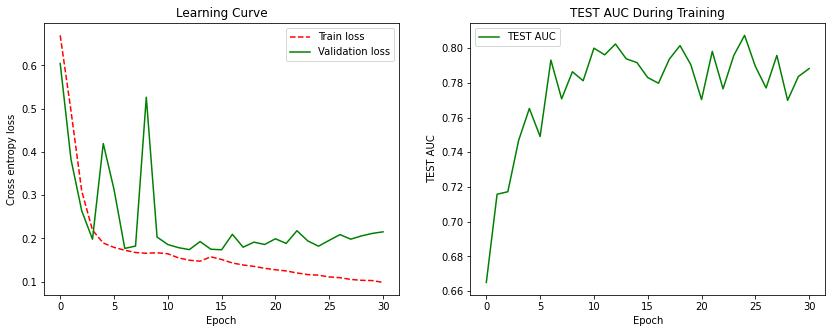


 Test AUC is 0.7829899787902832


In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 100)
        self.linear_2 = nn.Linear(100, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(100)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 40/200] Train_Loss: 0.06780 Valid_Loss: 0.23896 Test_AUC: 0.76286
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 690.1003220081329 seconds in cuda:0




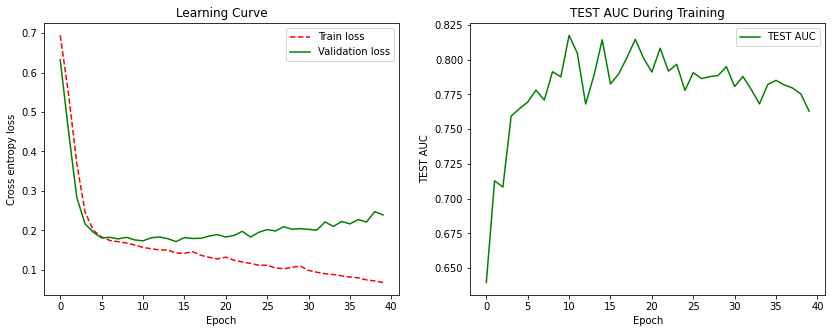


 Test AUC is 0.8141297499338785
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

4026065

In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 28/200] Train_Loss: 0.09729 Valid_Loss: 0.20362 Test_AUC: 0.77683
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 489.48388504981995 seconds in cuda:0




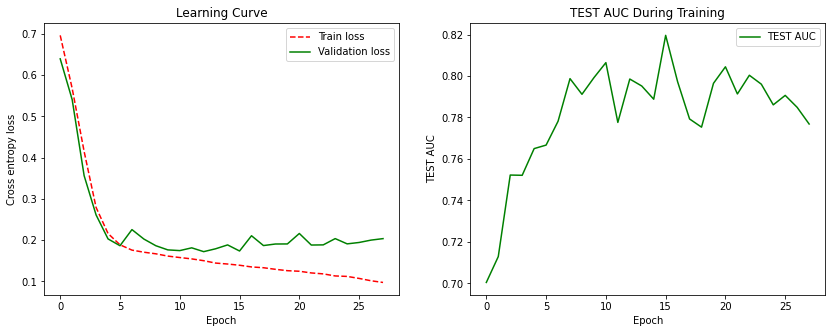


 Test AUC is 0.7985304196675619


In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 50)
        self.linear_2 = nn.Linear(50, 12)
        self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 28/200] Train_Loss: 0.10529 Valid_Loss: 0.20359 Test_AUC: 0.78407
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 482.2779679298401 seconds in cuda:0




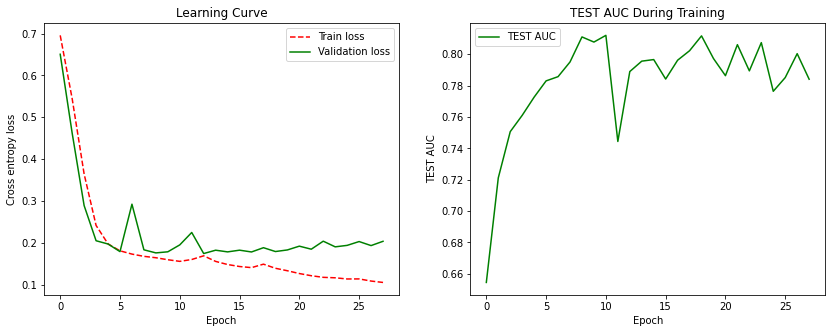


 Test AUC is 0.7889546553293864


In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 24/200] Train_Loss: 0.10012 Valid_Loss: 0.20363 Test_AUC: 0.79562
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 412.98575353622437 seconds in cuda:0




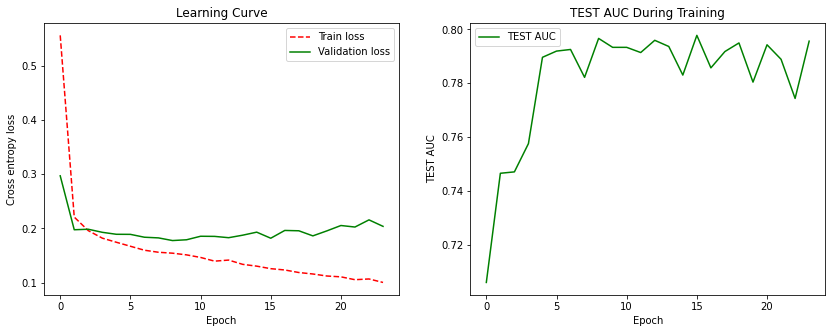


 Test AUC is 0.7966396808624268


In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        #self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      #output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 16/200] Train_Loss: 0.08567 Valid_Loss: 0.19750 Test_AUC: 0.79388
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 273.5425138473511 seconds in cuda:0




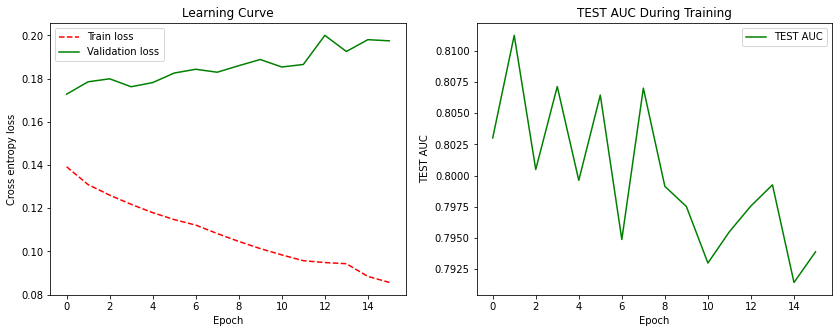


 Test AUC is 0.8030163447062174
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

4026065

In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=128, optimizer=optimizer, patience=15, n_epochs=200)
#count_parameters(model)

[ 43/200] Train_Loss: 0.07986 Valid_Loss: 0.22576 Test_AUC: 0.79271
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 818.116693019867 seconds in cuda:0




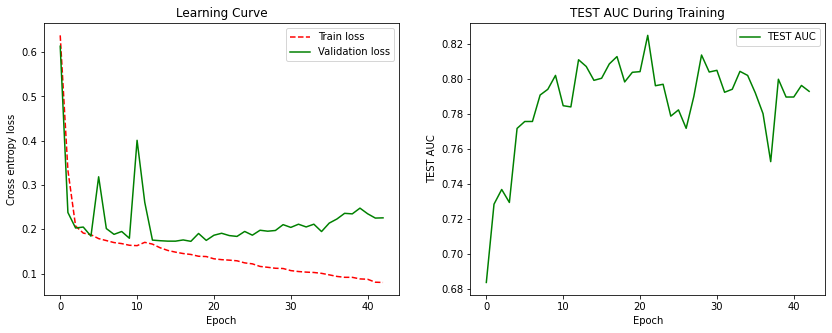


 Test AUC is 0.8125858306884766
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

4026065

In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN3 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 70)
        self.linear_2 = nn.Linear(70, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(70)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN2(mol_dgl_graph, fg)
      output = self.GNN3(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 34/200] Train_Loss: 0.09188 Valid_Loss: 0.20217 Test_AUC: 0.79323
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 1908.9949550628662 seconds in cpu




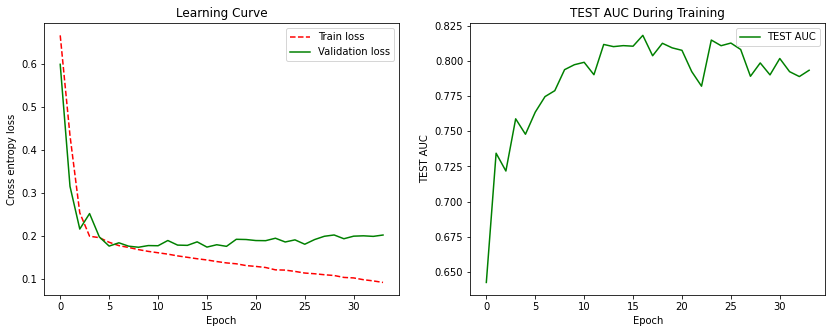


 Test AUC is 0.7936600844065348


ValueError: ignored

In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 18/200] Train_Loss: 0.11858 Valid_Loss: 0.17293 Test_AUC: 0.81378
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1005.1720254421234 seconds in cpu




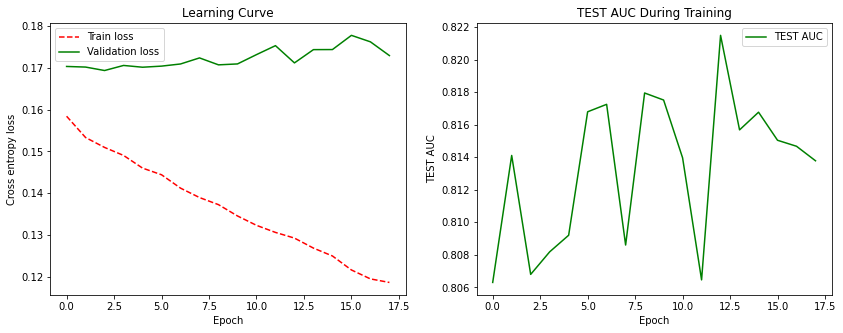


 Test AUC is 0.8067977428436279


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses, train_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)

[ 22/200] Train_Loss: 0.14386 Valid_Loss: 0.16876 Test_AUC: 0.81096
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1211.3712725639343 seconds in cpu




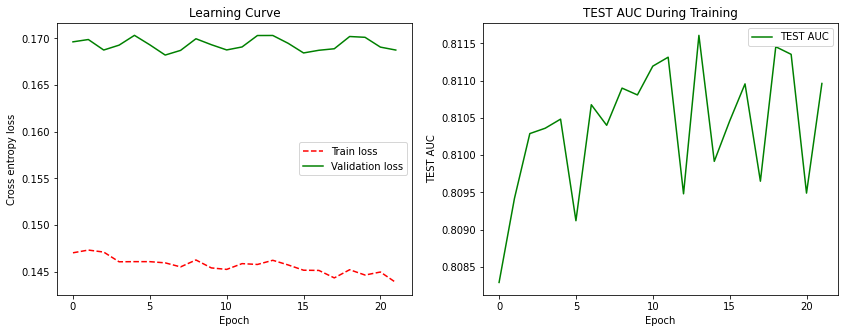


 Test AUC is 0.8106772104899088


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.00005)
model, train_losses, val_losses, train_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)

[ 20/200] Train_Loss: 0.13971 Valid_Loss: 0.17029 Test_AUC: 0.81643
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1113.1312110424042 seconds in cpu




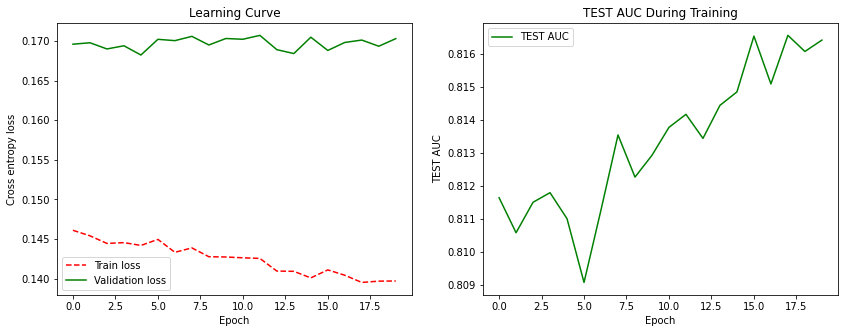


 Test AUC is 0.8110027313232422


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
model, train_losses, val_losses, train_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)

[ 40/200] Train_Loss: 0.07634 Valid_Loss: 0.24317 Test_AUC: 0.79765
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 2219.354187965393 seconds in cpu




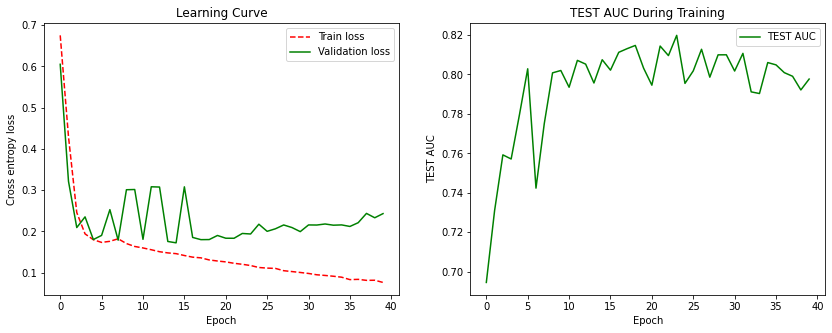


 Test AUC is 0.8074443340301514


ValueError: ignored

In [ ]:
# with cat
seed_value= 1024 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 39/200] Train_Loss: 0.06898 Valid_Loss: 0.26214 Test_AUC: 0.77299
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 3354.9308638572693 seconds in cpu




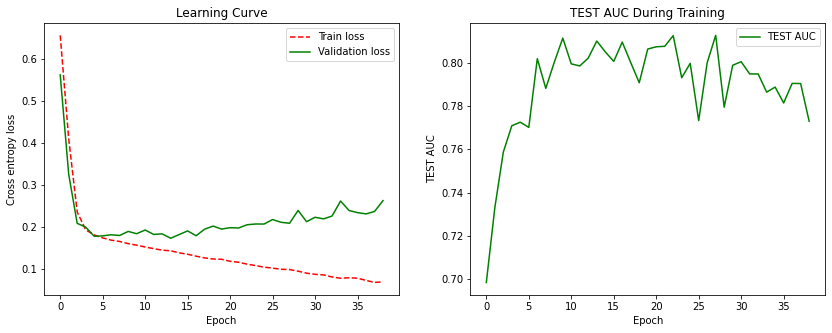


 Test AUC is 0.8100570837656657
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2049974

In [ ]:
# with cat
seed_value= 1024 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,10,10,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,10,10,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(29,19,200,200,200,200,200,200,200,200,200,200,1,200,200, num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100, num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
# checking over smoothing and alph behavior
# with cat
model.eval()
au_i_std_mean = 0
nf_std_mean = 0
ef_std_mean = 0
alpha_std_mean = 0
au_i_std_mean_list = []
length = 0
_, _, test_dataloader = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   out = model.GNN1(mol_dgl_graph, fg)
   au_i_std_mean += torch.std(out[3], 0).mean().item()
   au_i_std_mean_list.append(torch.std(out[3], 0).mean().item())
   nf_std_mean += torch.std(out[1], 0).mean().item()
   ef_std_mean += torch.std(out[2], 0).mean().item()
   alpha_std_mean += out[-1][-1].std().item()
   length += 1
  #  if i == 0:
  #    break
print('\n', nf_std_mean/length,'\n',ef_std_mean/length, '\n\n Alpha: \n',au_i_std_mean/length,'\n',alpha_std_mean/length,)

_, _, test_dataloader = loader(700)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(test_dataloader):
   out = model.GNN1(mol_dgl_graph, fg)
print('\n', torch.mean(out[1],0),torch.std(out[1], 0),torch.std(out[1], 0).mean())
print('\n', torch.mean(out[2],0),torch.std(out[2], 0),torch.std(out[2], 0).mean())
print('\n', torch.mean(out[3],0),torch.std(out[3], 0),torch.std(out[3], 0).mean())
print('\n', torch.mean(out[4],0),torch.std(out[4], 0),torch.std(out[4], 0).mean())


 0.5166314945882543 
 0.44692574353779063 

 Alpha: 
 nan 
 0.0

 tensor([0.3414, 0.3548, 0.3980, 0.3078, 0.3311, 0.4153, 0.4955, 0.3949, 0.5328,
        0.2678, 0.3317, 0.3770, 0.2781, 0.4387, 0.5165, 0.3311, 0.4507, 0.3714,
        0.5087, 0.3845, 0.5013, 0.3946, 0.4025, 0.3857, 0.3874, 0.4042, 0.3889,
        0.3865, 0.3342, 0.2850, 0.4869, 0.4748, 0.4159, 0.3679, 0.3715, 0.3753,
        0.4390, 0.4618, 0.4178, 0.4937], grad_fn=<MeanBackward1>) tensor([0.5928, 0.7502, 0.6926, 0.7924, 0.5307, 0.5386, 0.7750, 0.5330, 0.5957,
        0.5384, 0.6934, 0.5150, 0.6998, 0.6131, 0.6915, 0.7883, 0.8464, 0.6673,
        0.6532, 0.7016, 0.8147, 0.5755, 0.6058, 0.5980, 0.9078, 0.7646, 0.5218,
        0.7885, 0.5381, 0.6571, 0.6383, 0.6727, 0.4424, 0.5119, 0.6440, 0.6134,
        0.5533, 0.5371, 0.7447, 0.8711], grad_fn=<StdBackward1>) tensor(0.6552, grad_fn=<MeanBackward0>)

 tensor([0.4410, 0.4438, 0.4296, 0.5521, 0.4588, 0.3529, 0.4347, 0.3716, 0.4846,
        0.4042, 0.4561, 0.3838, 0.5590, 

In [ ]:
# with cat
seed_value= 1 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,10,10,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,10,10,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _, _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 22/200] Train_Loss: 0.11826 Valid_Loss: 0.18583 Test_AUC: 0.79866
EarlyStopping counter: 9 out of 25


[ 22/200] Train_Loss: 0.09413 Valid_Loss: 0.21045 Test_AUC: 0.76396
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1476.5904982089996 seconds in cpu




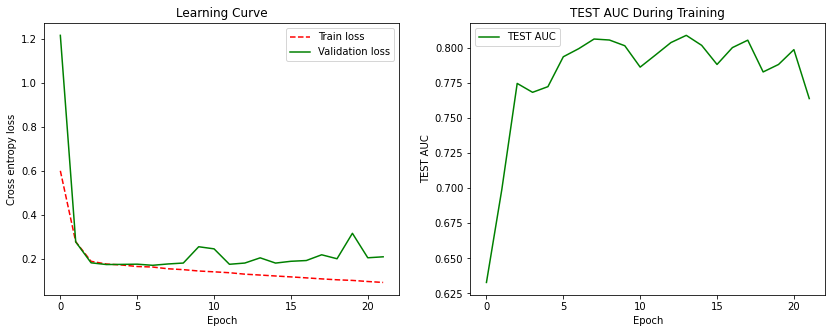


 Test AUC is 0.7995417912801107
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   540000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

1796593

In [ ]:
# with cat
seed_value= 123 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,10,10,num_layers=1)
        self.linear_1 = nn.Linear(300, 100)
        self.linear_2 = nn.Linear(100, 12)
        self.bn = nn.BatchNorm1d(100)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 25/200] Train_Loss: 0.13922 Valid_Loss: 0.18612 Test_AUC: 0.79385
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 232.3045620918274 seconds in cpu




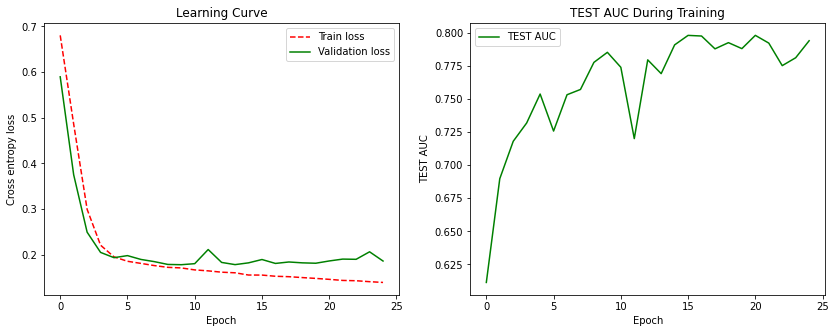


 Test AUC is 0.7851133346557617
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    6520    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

85233

In [ ]:
# with cat
seed_value= 1024 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 32/200] Train_Loss: 0.12221 Valid_Loss: 0.19294 Test_AUC: 0.76716
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 298.7635259628296 seconds in cpu




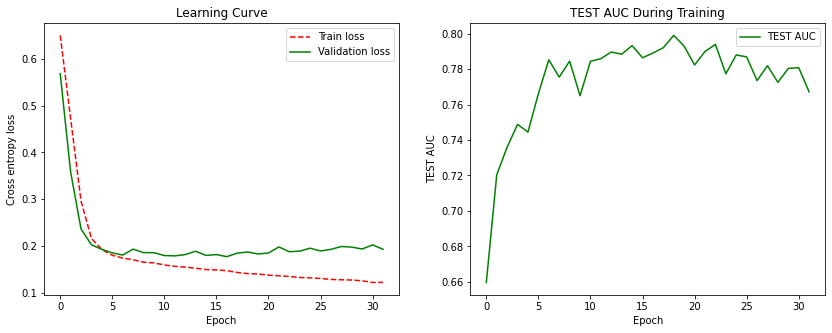


 Test AUC is 0.7890482743581136
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    6520    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    9600    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

85233

In [ ]:
# with cat
seed_value= 123 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 26/200] Train_Loss: 0.12747 Valid_Loss: 0.19065 Test_AUC: 0.78831
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 232.63758444786072 seconds in cpu




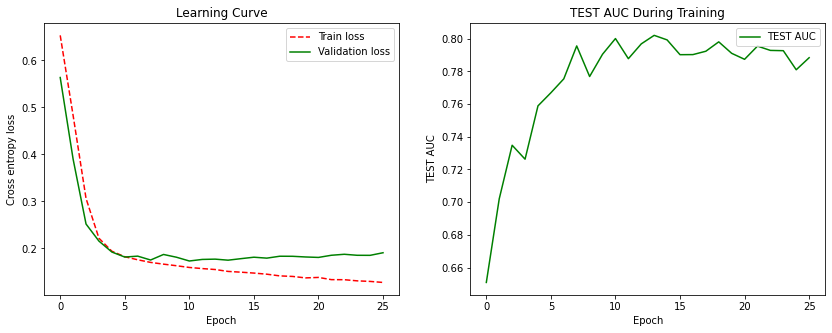


 Test AUC is 0.8000205357869467
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    6520    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    6400    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

82033

In [ ]:
# with cat_0
seed_value= 123 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 33/200] Train_Loss: 0.12389 Valid_Loss: 0.19706 Test_AUC: 0.80070
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 296.63096809387207 seconds in cpu




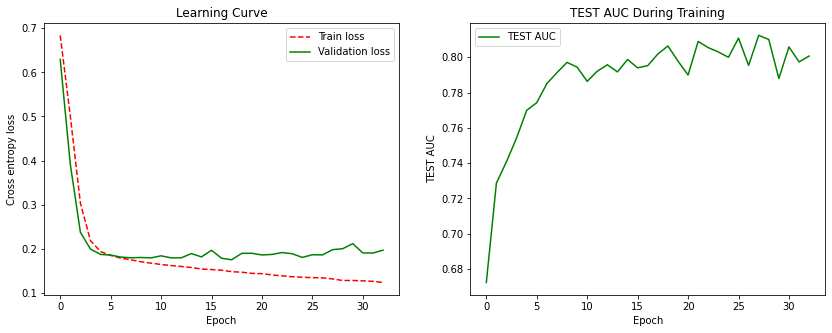


 Test AUC is 0.8018170992533366
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    6520    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    6400    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

56353

In [ ]:
seed_value= 123 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

In [ ]:
out[-1].shape

torch.Size([3, 2660])

[ 38/200] Train_Loss: 0.07191 Valid_Loss: 0.24150 Test_AUC: 0.78203
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 3030.4324362277985 seconds in cpu




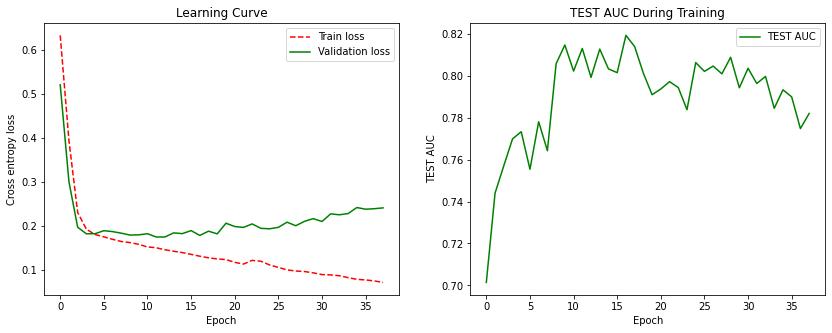


 Test AUC is 0.7992468674977621
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   360000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2624814

In [ ]:
seed_value= 123 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.GNN2 = GGNN(300,300,300,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 40)
        self.linear_2 = nn.Linear(40, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(40)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 38/200] Train_Loss: 0.09416 Valid_Loss: 0.21574 Test_AUC: 0.78285
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 2025.6701514720917 seconds in cpu




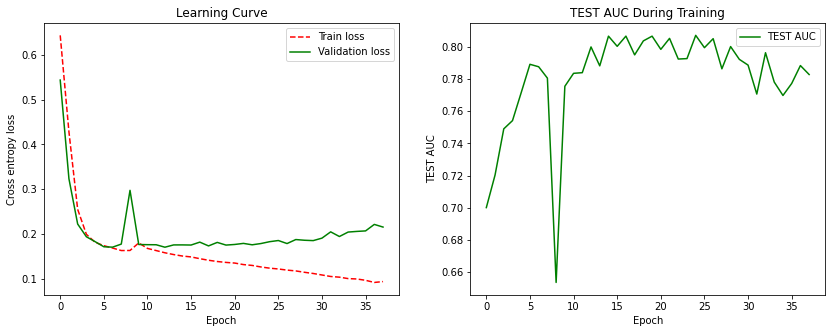


 Test AUC is 0.7999982039133707


ValueError: ignored

In [ ]:
seed_value= 123 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.GNN2 = GGNN(200,200,200,100,100,100,100,100,100,100,100,100,1,100,100,num_layers=1)
        self.linear_1 = nn.Linear(100, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      (fg, mol_dgl_graph.ndata['h_0'], mol_dgl_graph.edata['e_0'], _) = self.GNN1(mol_dgl_graph,fg)
      output = self.GNN2(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 24/200] Train_Loss: 0.07493 Valid_Loss: 0.27875 Test_AUC: 0.76594
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1503.3844690322876 seconds in cpu




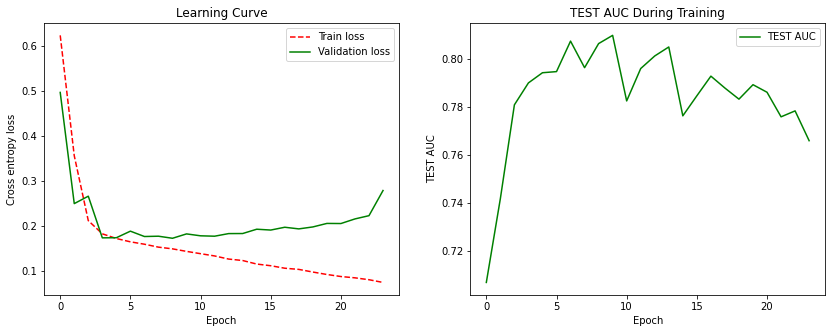


 Test AUC is 0.8063457012176514
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   360000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2302063

In [ ]:
seed_value= 10 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.linear_1 = nn.Linear(300, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 24/200] Train_Loss: 0.07738 Valid_Loss: 0.22908 Test_AUC: 0.76711
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1488.5336391925812 seconds in cpu




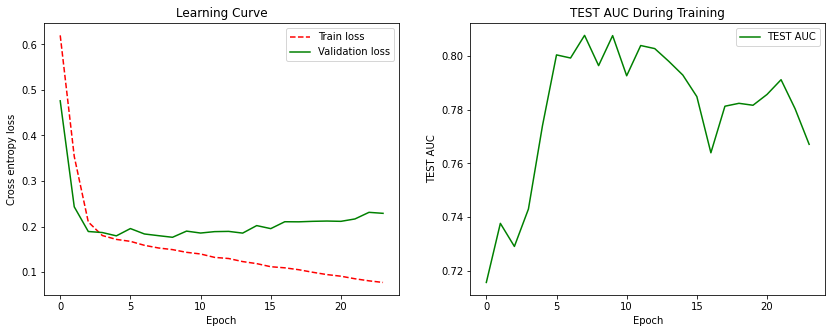


 Test AUC is 0.7963772614796957
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   360000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2302063

In [ ]:
seed_value= 1024 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.linear_1 = nn.Linear(300, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 22/200] Train_Loss: 0.09079 Valid_Loss: 0.22347 Test_AUC: 0.79573
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1388.557165145874 seconds in cpu




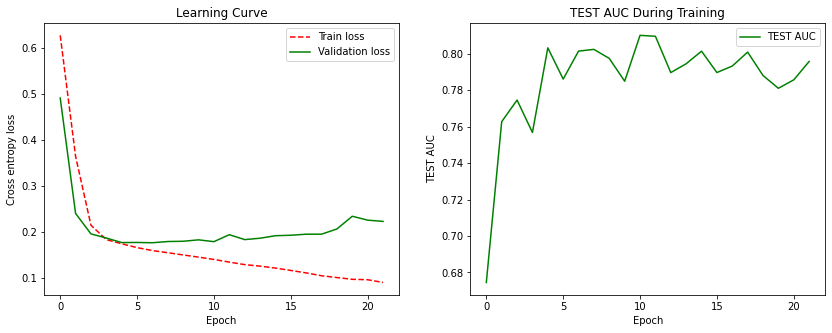


 Test AUC is 0.8014055093129476
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   360000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2302063

In [ ]:
seed_value= 213 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.linear_1 = nn.Linear(300, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[2/2] Train_Loss: 0.36485 Valid_Loss: 0.24072 Test_AUC: 0.76269
Validation loss decreased (0.491667 --> 0.240717).  Saving model ...

 Training Time was 125.91465973854065 seconds in cpu




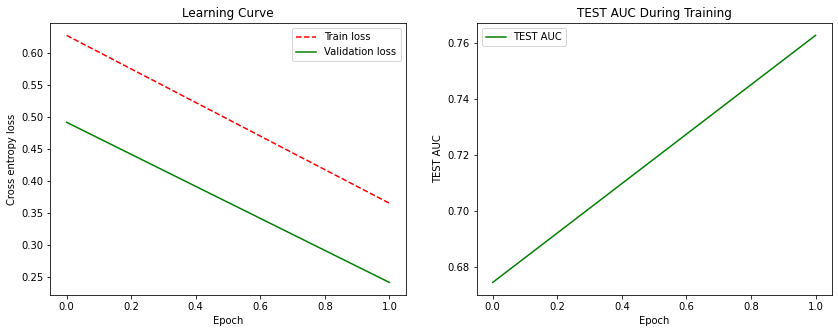


 Test AUC is 0.7626938819885254
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   360000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2302063

In [ ]:
seed_value= 213 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.linear_1 = nn.Linear(300, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=2)
count_parameters(model)

[2/2] Train_Loss: 0.36485 Valid_Loss: 0.24072 Test_AUC: 0.76269
Validation loss decreased (0.491667 --> 0.240717).  Saving model ...

 Training Time was 121.47368884086609 seconds in cpu




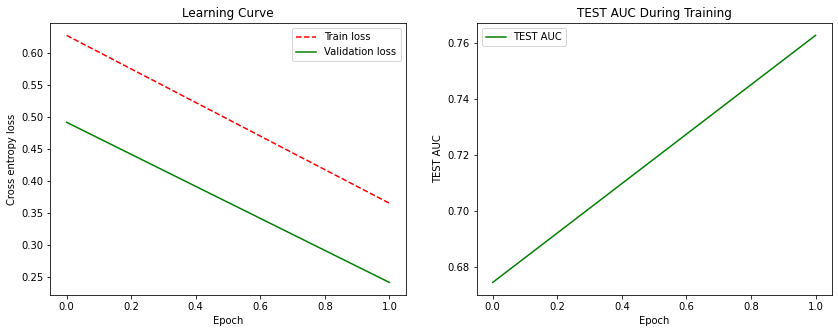


 Test AUC is 0.7626938819885254
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   48900    |
|    GNN1.linear_0_v.bias    |    300     |
|     GNN1.bn_0_v.weight     |    300     |
|      GNN1.bn_0_v.bias      |    300     |
|   GNN1.linear_0_e.weight   |    5700    |
|    GNN1.linear_0_e.bias    |    300     |
|     GNN1.bn_0_e.weight     |    300     |
|      GNN1.bn_0_e.bias      |    300     |
|   GNN1.linear_0_g.weight   |   60000    |
|    GNN1.linear_0_g.bias    |    300     |
|     GNN1.bn_0_g.weight     |    300     |
|      GNN1.bn_0_g.bias      |    300     |
|   GNN1.linear_e_0.weight   |   360000   |
|    GNN1.linear_e_0.bias    |    300     |
|     GNN1.bn_e_0.weight     |    300     |
|      GNN1.bn_e_0.bias      |    300     |
|   GNN1.linear_e_1.weight   |   90000    |
|    GNN1.linear_e_1.bias    |    300     |
|     GNN1.bn_e_1.weight     |    300     |

2302063

In [ ]:
seed_value= 213 
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
dgl.seed(seed_value)
class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.linear_1 = nn.Linear(300, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=2)
count_parameters(model)

[ 23/200] Train_Loss: 0.09964 Valid_Loss: 0.21546 Test_AUC: 0.79406
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 1405.8224663734436 seconds in cpu




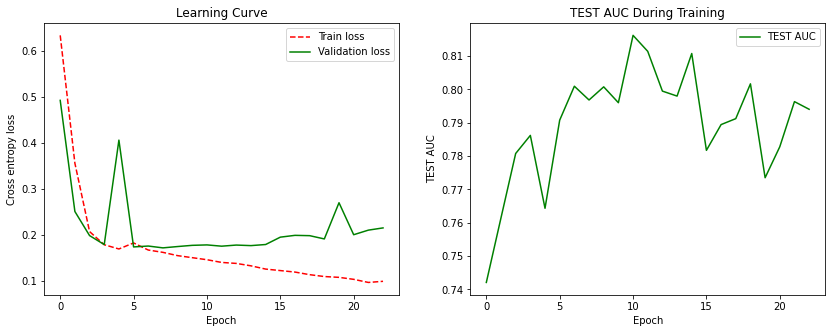


 Test AUC is 0.7968440850575765


ValueError: ignored

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,300,300,300,300,300,300,300,300,300,1,300,300,num_layers=1)
        self.linear_1 = nn.Linear(300, 50)
        self.linear_2 = nn.Linear(50, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(50)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, train_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 22/200] Train_Loss: 0.09485 Valid_Loss: 0.22295 Test_AUC: 0.78843
EarlyStopping counter: 15 out of 15
Early Stopping

 Training Time was 767.8342406749725 seconds in cpu




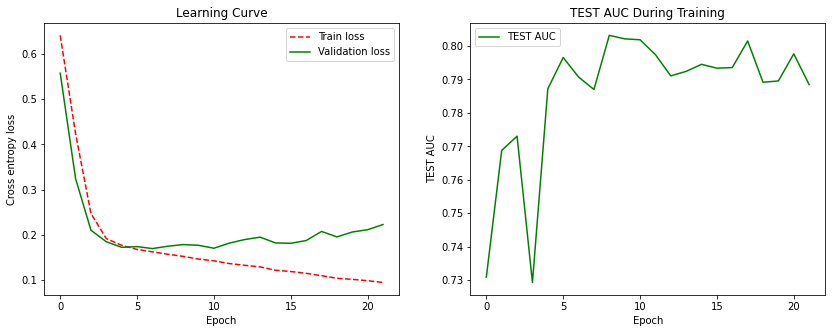


 Test AUC is 0.790709654490153


ValueError: ignored

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=1)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, train_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=15, n_epochs=200)
count_parameters(model)

[ 32/200] Train_Loss: 0.06195 Valid_Loss: 0.25928 Test_AUC: 0.76614
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 502.7497081756592 seconds in cpu




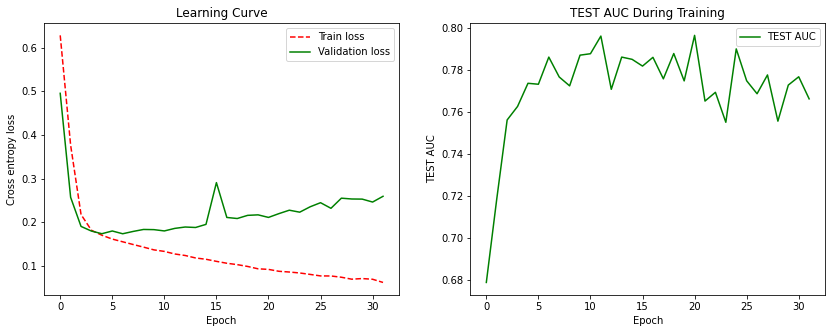


 Test AUC is 0.7860427697499593
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |   16300    |
|    GNN1.linear_0_v.bias    |    100     |
|     GNN1.bn_0_v.weight     |    100     |
|      GNN1.bn_0_v.bias      |    100     |
|   GNN1.linear_0_e.weight   |    950     |
|    GNN1.linear_0_e.bias    |     50     |
|     GNN1.bn_0_e.weight     |     50     |
|      GNN1.bn_0_e.bias      |     50     |
|   GNN1.linear_0_g.weight   |   30000    |
|    GNN1.linear_0_g.bias    |    150     |
|     GNN1.bn_0_g.weight     |    150     |
|      GNN1.bn_0_g.bias      |    150     |
|   GNN1.linear_e_0.weight   |   30000    |
|    GNN1.linear_e_0.bias    |    100     |
|     GNN1.bn_e_0.weight     |    100     |
|      GNN1.bn_e_0.bias      |    100     |
|   GNN1.linear_e_1.weight   |    5000    |
|    GNN1.linear_e_1.bias    |     50     |
|     GNN1.bn_e_1.weight     |     50     |

239233

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,100,50,150,100,100,50,150,150,150,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(150, 50)
        self.linear_2 = nn.Linear(50, 12)
        self.bn = nn.BatchNorm1d(50)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 36/200] Train_Loss: 0.13741 Valid_Loss: 0.18547 Test_AUC: 0.79468
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 315.8208472728729 seconds in cpu




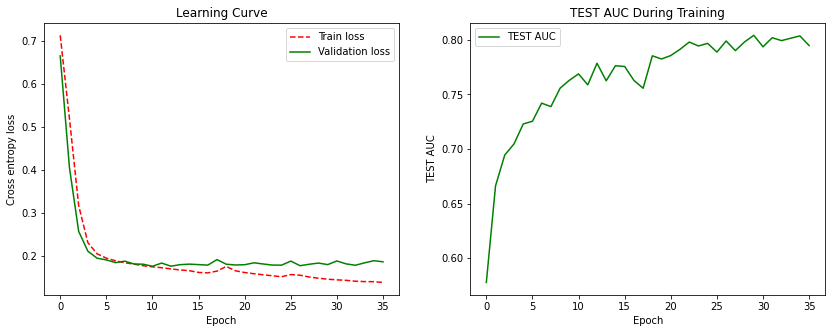


 Test AUC is 0.7687654495239258
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    6520    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    6400    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

56353

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 52/200] Train_Loss: 0.11653 Valid_Loss: 0.20808 Test_AUC: 0.78766
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 457.78984212875366 seconds in cpu




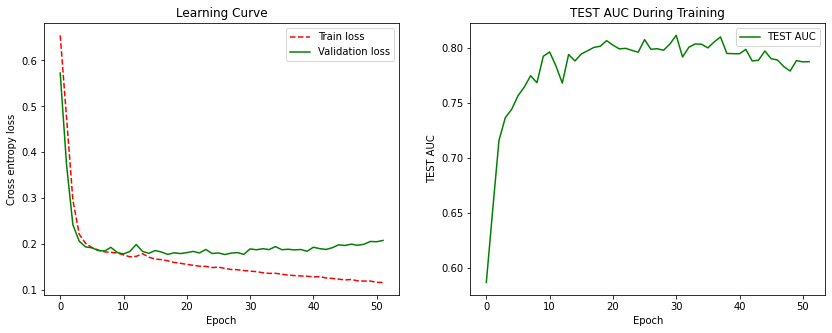


 Test AUC is 0.7988635698954264
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    6520    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    6400    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

56353

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

[ 38/200] Train_Loss: 0.12388 Valid_Loss: 0.19596 Test_AUC: 0.79302
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 333.1142203807831 seconds in cpu




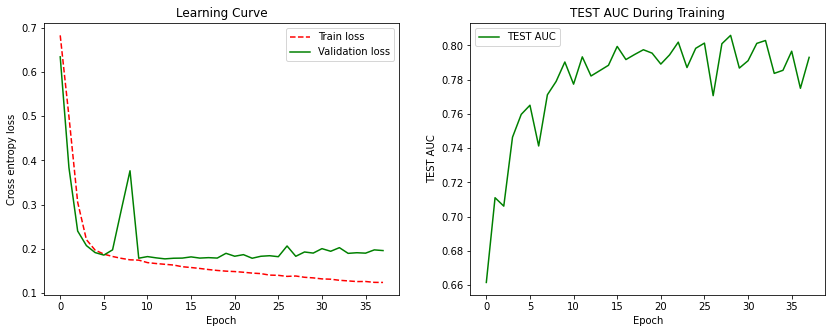


 Test AUC is 0.7821489969889323
+----------------------------+------------+
|          Modules           | Parameters |
+----------------------------+------------+
|   GNN1.linear_0_v.weight   |    6520    |
|    GNN1.linear_0_v.bias    |     40     |
|     GNN1.bn_0_v.weight     |     40     |
|      GNN1.bn_0_v.bias      |     40     |
|   GNN1.linear_0_e.weight   |    760     |
|    GNN1.linear_0_e.bias    |     40     |
|     GNN1.bn_0_e.weight     |     40     |
|      GNN1.bn_0_e.bias      |     40     |
|   GNN1.linear_0_g.weight   |    8000    |
|    GNN1.linear_0_g.bias    |     40     |
|     GNN1.bn_0_g.weight     |     40     |
|      GNN1.bn_0_g.bias      |     40     |
|   GNN1.linear_e_0.weight   |    6400    |
|    GNN1.linear_e_0.bias    |     40     |
|     GNN1.bn_e_0.weight     |     40     |
|      GNN1.bn_e_0.bias      |     40     |
|   GNN1.linear_e_1.weight   |    1600    |
|    GNN1.linear_e_1.bias    |     40     |
|     GNN1.bn_e_1.weight     |     40     |

56353

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,40,40,40,40,40,40,40,40,40,1,40,40,num_layers=1)
        self.linear_1 = nn.Linear(40, 20)
        self.linear_2 = nn.Linear(20, 12)
        self.bn = nn.BatchNorm1d(20)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model, train_losses, val_losses, test_aucs = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
m= torch.empty(0, device=device)
s= torch.empty(0, device=device)
# model.eval()
# _, val_dataloader, _ = loader(1)
# for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
#   mol_dgl_graph=mol_dgl_graph.to(device)
#   fg= fg.to(device)
#   mean = torch.cat((mean, model.GNN1(mol_dgl_graph, fg)[-1][-1].mean()),1)
#   std = torch.cat((std, model.GNN1(mol_dgl_graph, fg)[-1][-1].std()),0)
# print(mean.mean(),std.mean())

In [ ]:
torch.cat((m,torch.Tensor([0])),0)

RuntimeError: ignored

In [ ]:
torch.cat((mean, model.GNN1(mol_dgl_graph, fg)[-1][-1].mean()),1)

In [ ]:
  mean = torch.cat((mean, model.GNN1(mol_dgl_graph, fg)[-1][-1].mean()),0)
  std = torch.cat((std, model.GNN1(mol_dgl_graph, fg)[-1][-1].std()),0)

In [ ]:
type(model.GNN1(mol_dgl_graph, fg)[-1][-1].mean())

torch.Tensor

In [ ]:
model.GNN1(mol_dgl_graph, fg)[-1][-1].mean().item()

1.0

In [ ]:
model.GNN1(mol_dgl_graph, fg)[-1][-1].std()

tensor(0., device='cuda:0', grad_fn=<StdBackward0>)

In [ ]:
model.eval()
_, val_dataloader, _ = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
  mol_dgl_graph=mol_dgl_graph.to(device)
  fg= fg.to(device)
  break
model.GNN1(mol_dgl_graph, fg)[-1]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]], grad_fn=<CatBackward>)

[ 29/200] Train_Loss: 0.09505 Valid_Loss: 0.48163 Test_AUC: 0.49741
EarlyStopping counter: 25 out of 25
Early Stopping

 Training Time was 4154.8189470767975 seconds in cpu




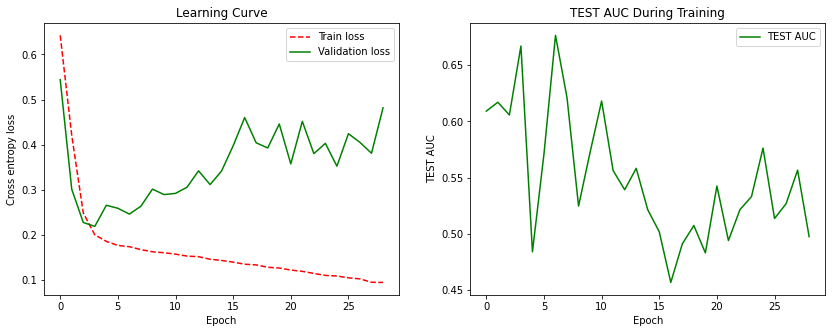


 Test AUC is 0.6670538584391276


ValueError: ignored

In [ ]:

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.GNN1 = GGNN(163,19,200,200,200,200,200,200,200,200,200,200,1,200,200,num_layers=3)
        self.linear_1 = nn.Linear(200, 30)
        self.linear_2 = nn.Linear(30, 12)
        #self.bn = nn.BatchNorm1d(30)
        self.bn1 = nn.BatchNorm1d(30)
        #self.bn2 = nn.BatchNorm1d(12)
        self.reset_parameters()
    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('sigmoid')
        nn.init.xavier_normal_(self.linear_1.weight, gain=gain)
        nn.init.xavier_normal_(self.linear_2.weight, gain=gain)  
    def forward(self, mol_dgl_graph,fg):
      output = self.GNN1(mol_dgl_graph,fg)[0]
      output = nn.functional.relu(self.linear_1(output))
      output = self.bn1(output)
      output = nn.functional.sigmoid(self.linear_2(output))     
      return output
model= GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model, train_losses, val_losses = train_model(model, batch_size=64, optimizer=optimizer, patience=25, n_epochs=200)
count_parameters(model)

In [ ]:
model.eval()
_, val_dataloader, _ = loader(1)
for i, (_, mol_dgl_graph, fg, labels, masks) in enumerate(val_dataloader):
  mol_dgl_graph=mol_dgl_graph.to(device)
  fg= fg.to(device)
  break
model.GNN1(mol_dgl_graph, fg)[-1]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.8080, 0.7872, 0.7704, 0.7915, 0.7838, 0.7749, 0.7762, 0.8270, 0.7812,
         0.7951, 0.7886, 0.7931, 0.7903, 0.7910, 0.8375, 0.7984, 0.8034, 0.8251,
         0.8034, 0.8251, 0.8041, 0.7780, 0.8008, 0.8371],
        [0.8943, 0.8905, 0.8942, 0.8964, 0.8883, 0.8868, 0.8792, 0.8852, 0.8871,
         0.8882, 0.8787, 0.8845, 0.8833, 0.8790, 0.8768, 0.8867, 0.8859, 0.8758,
         0.8859, 0.8758, 0.8931, 0.8926, 0.8879, 0.8768],
        [0.6514, 0.5560, 0.6101, 0.6464, 0.6329, 0.5774, 0.5045, 0.6251, 0.6353,
         0.6860, 0.6617, 0.6795, 0.7014, 0.6577, 0.7608, 0.7060, 0.5713, 0.7304,
         0.5713, 0.7304, 0.6815, 0.6888, 0.6945, 0.7630]], device='cuda:0',
       grad_fn=<CatBackward>)

In [ ]:
weight_sum=torch.tensor([0.08, 0.08, 0.08, 0.08, 0.1, 0.1, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08]).to(device)
def my_loss(output, label, mask=None):
    # criterion = torch.nn.BCELoss(reduction='none').to(device)
    criterion = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight).to(device)
    if mask == None:
        # loss = torch.sum(torch.mean(criterion(output,label), axis=1))
        loss = torch.sum(torch.sum((weight_sum*criterion(output,label)), axis=1))
    else: 
        # loss = torch.sum(torch.mean(mask*criterion(output,label), axis=1))
        loss = torch.sum(torch.sum(mask*(weight_sum*criterion(output,label)), axis=1))
    return loss